# Calculate CAPE for a Littlerock sounding

In [63]:
import numpy as np
import pandas as pd
import h5py
from pprint import pformat
from importlib import reload
import a405thermo.thermlib
reload(a405thermo.thermlib)
from a405thermo.constants import constants as c
from a405thermo.thermlib import convertSkewToTemp, convertTempToSkew
import a405skewT.makeSkewII
reload(a405skewT.makeSkewII)
from a405skewT.makeSkewII import makeSkewWet

In [64]:
filename='out.h5';
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[0]]
# print('{0:}sounding times:{1:}{0:} '.format(separator,times))
# print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]

reading file: out.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 1.0,
 'header': '78486 MDSD Santo Domingo Observations at 12Z 01 Jul 2015',
 'history': 'written by test_requests.py',
 'latitude': 18.43,
 'longitude': -69.879999999999995,
 'query': 'http://weather.uwyo.edu/cgi-bin/sounding?region=samer&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=7&FROM=0100&TO=0300&STNM=78486',
 'site_id': '78486',
 'timestamp': '2016-02-12 16:26:13 UTC',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}
title: : 78486 MDSD Santo Domingo at 2015_Jul_01_12Z


In [65]:
skew=30.
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))

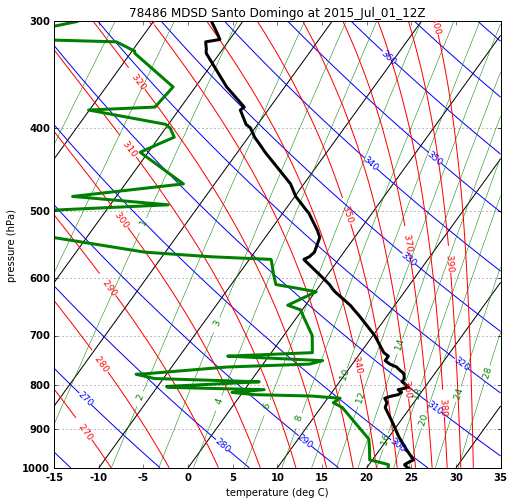

In [66]:
%matplotlib inline
skew=30
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners=[-15,35]
ax,skew = makeSkewWet(ax,corners=corners,skew=skew)
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in ax.lines[-2:]]
out=ax.set(title=title)

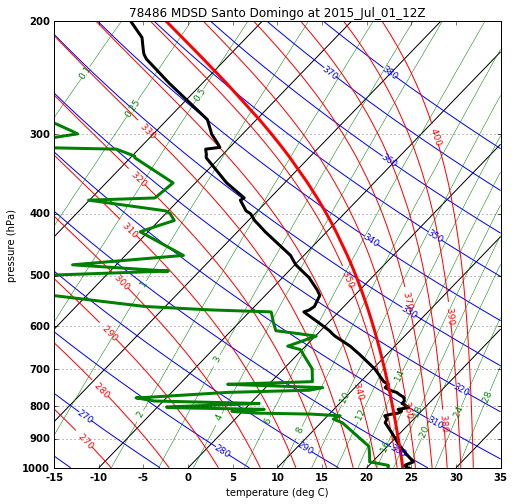

In [67]:
from a405thermo.thermlib import find_Tmoist,find_thetaep,find_rsat,find_Tv
#
# find thetae of the surface air
#
sfc_press,sfc_temp,sfc_td =[sounding[key][0] for key in ['pres','temp','dwpt']]
sfc_press,sfc_temp,sfc_td = sfc_press*100.,sfc_temp+c.Tc,sfc_td+c.Tc
sfc_rvap = find_rsat(sfc_temp,sfc_press)
sfc_thetae=find_thetaep(sfc_td,sfc_temp,sfc_press)
press=sounding['pres'].values*100.
#
# find the index for 200 hPa pressure -- searchsorted requires
# the pressure array to be increasing, so flip it for the search,
# then flip the index.  Above 200 hPa thetae goes bananas, so
# so trim so we only have 
#
toplim=len(press) - np.searchsorted(press[::-1],2.e4)
press=press[:toplim]
#
# find temps along that adiabat
#
adia_temps= np.array([find_Tmoist(sfc_thetae,the_press) for the_press in press])
adia_rvaps = find_rsat(adia_temps,press)
adia_rls = sfc_rvap - adia_rvaps
env_temps = (sounding['temp'].values + c.Tc)[:toplim]
env_Td = (sounding['dwpt'].values + c.Tc)[:toplim]
height = sounding['hght'].values[:toplim]
pairs = zip(env_Td,press)
env_rvaps= np.array([find_rsat(td,the_press) for td,the_press in pairs])
env_Tv = find_Tv(env_temps,env_rvaps)
adia_Tv = find_Tv(adia_temps,adia_rvaps,adia_rls)
xcoord_thetae=[]
press_hPa = press*1.e-2
for a_temp,a_press in zip(adia_temps - c.Tc,press_hPa):
    out=convertTempToSkew(a_temp,a_press,skew)
    xcoord_thetae.append(out)
ax.plot(xcoord_thetae,press_hPa,color='r',label='rsat',linewidth=3.)
ax.set(ylim=[1000.,200.])
display(fig)


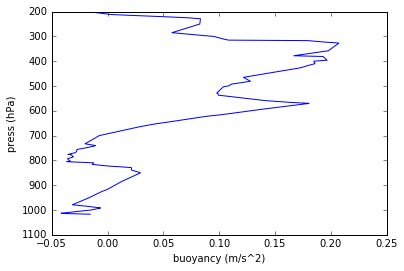

In [68]:
def find_buoy(adia_Tv,env_Tv):
  buoy=c.g0*(adia_Tv - env_Tv)/env_Tv
  return buoy

#
# moved find_buoy to library
#
from a405thermo.thermlib import find_buoy
    
fig,ax =plt.subplots(1,1)
buoy=find_buoy(adia_Tv,env_Tv)
ax.plot(buoy,press*1.e-2)
ax.invert_yaxis()
out=ax.set(ylabel='press (hPa)',xlabel='buoyancy (m/s^2)')

### Find the bottom and top buoyancy zero crossings

In [69]:
#np.searchsorted finds the first crossing
zerobot=np.searchsorted(buoy,0)
#flip the array and search backwards for top crossing
zerotop=len(buoy) - np.searchsorted(buoy[::-1],0)
print('pressure levels for crossing: {} hPa {} hPa'\
      .format(press[zerobot]*0.01,press[zerotop]*0.01))

pressure levels for crossing: 664.0 hPa 200.0 hPa


### find the cape

In [70]:
clipped_buoy = buoy[zerobot:zerotop]
clipped_height = height[zerobot:zerotop]
#average the levels to get layer buoyancy
layer_buoy = (clipped_buoy[:-1] + clipped_buoy[1:])/2.
cape = np.sum(layer_buoy*np.diff(clipped_height))
print('cape is {:6.2f} J/kg'.format(cape))

cape is 1040.12 J/kg


### Hadleigh's: use cape to find updraft veolcities

In [71]:
# max updraft velocity
w_max = np.sqrt(2*cape)
print('max updraft is {:.3f} m/s'.format(w_max))

max updraft is 45.610 m/s


### Hadleigh's: level of neutral buoyancy (LNB)
top-down crossing of differnce function (buoy) as it crosses zero

In [72]:
# same as phaustins function for finding zerotop
lnb = len(buoy) - np.searchsorted(buoy[::-1],0)
print('Level of neutral buoyancy (LNB): {} hPa'\
      .format(press[lnb]*0.01))

Level of neutral buoyancy (LNB): 200.0 hPa


### Hadleigh's: finding height at which negative cape equals positive cape

In [73]:
overshoot_buoy = buoy[:lnb]
overshoot_height = height[:lnb]
layer_buoy = (overshoot_buoy[:-1] + overshoot_buoy[1:])/2.
layer_thickness = np.diff(overshoot_height)
neg_cape = 0.
count = 0

while np.abs(neg_cape) < cape:
    layer_cape = layer_buoy[count]*layer_thickness[count]
    neg_cape = neg_cape + layer_cape
    count = count+1
   
    if count == len(layer_buoy):
        print('Not enough neg cape in sounding')
        break
    
    max_height = press[count]
    
if np.abs(neg_cape) >= cape:
    print('Overshooting tops expected to reach {:2.2f} hPa'.format(max_height))

Not enough neg cape in sounding


### Hadeligh's: mixing fractions

### Finding max buoyancy

In [84]:
max_buoy = press[np.argmax(buoy)] / 100
print('Max buoyancy found at {:2.2f} hPa'.format(max_buoy))

adia_temp = adia_temps[np.argmax(buoy)]
environ_temp = env_temps[np.argmax(buoy)]



Max buoyancy found at 327.00 hPa


In [ ]:
f=np.linspace(0,1,20,endpoint=True)